In [1]:
# Testing gaussian file helpers
from utils.gaussian_file_helper import load_gaussians, save_gaussians
from utils.image_utils import render_and_save, render
import torch 
import matplotlib.pyplot as plt
from utils.diffusion_data_helper import normalize_data, denormalize_data, DiffusionScheduler

In [2]:
FILEPATH = "data/1 (40).jpeg.npz"
data = load_gaussians(FILEPATH, device="cuda:0" if torch.cuda.is_available() else "cpu")
xy: torch.Tensor = data["xy"]
scale: torch.Tensor = data["scale"]
rot: torch.Tensor = data["rot"]
feat: torch.Tensor = data["feat"]

img_w = data["img_w"]
img_h = data["img_h"]

image_size = (img_h, img_w)

In [3]:
original_image = render_and_save(xy=xy, scale=scale, rot=rot, feat=feat, img_size=image_size, path="output/rendered_image")   
xy_norm, scale_norm, rot_norm, feat_norm = normalize_data(xy, scale, rot, feat)
xy_orig, scale_orig, rot_orig, feat_orig = denormalize_data(xy_norm, scale_norm, rot_norm, feat_norm)
print("Max abs diff in xy:", torch.max(torch.abs(xy - xy_orig)).item())
print("Max abs diff in scale:", torch.max(torch.abs(scale - scale_orig)).item())
print("Max abs diff in rot:", torch.max(torch.abs(rot - rot_orig)).item())
print("Max abs diff in feat:", torch.max(torch.abs(feat - feat_orig)).item())

#Let's make sure the shapes are the same
assert xy.shape == xy_orig.shape, "xy shape mismatch after normalization and denormalization"
assert scale.shape == scale_orig.shape, "scale shape mismatch after normalization and denormalization"
assert rot.shape == rot_orig.shape, "rot shape mismatch after normalization and denormalization"
assert feat.shape == feat_orig.shape, "feat shape mismatch after normalization and denormalization"
norm_and_back = render_and_save(xy=xy_orig, scale=scale_orig, rot=rot_orig, feat=feat_orig, img_size=image_size, path="output/norm_and_back_image")

Max abs diff in xy: 1.1920928955078125e-07
Max abs diff in scale: 4.57763671875e-05
Max abs diff in rot: 0.0
Max abs diff in feat: 0.0


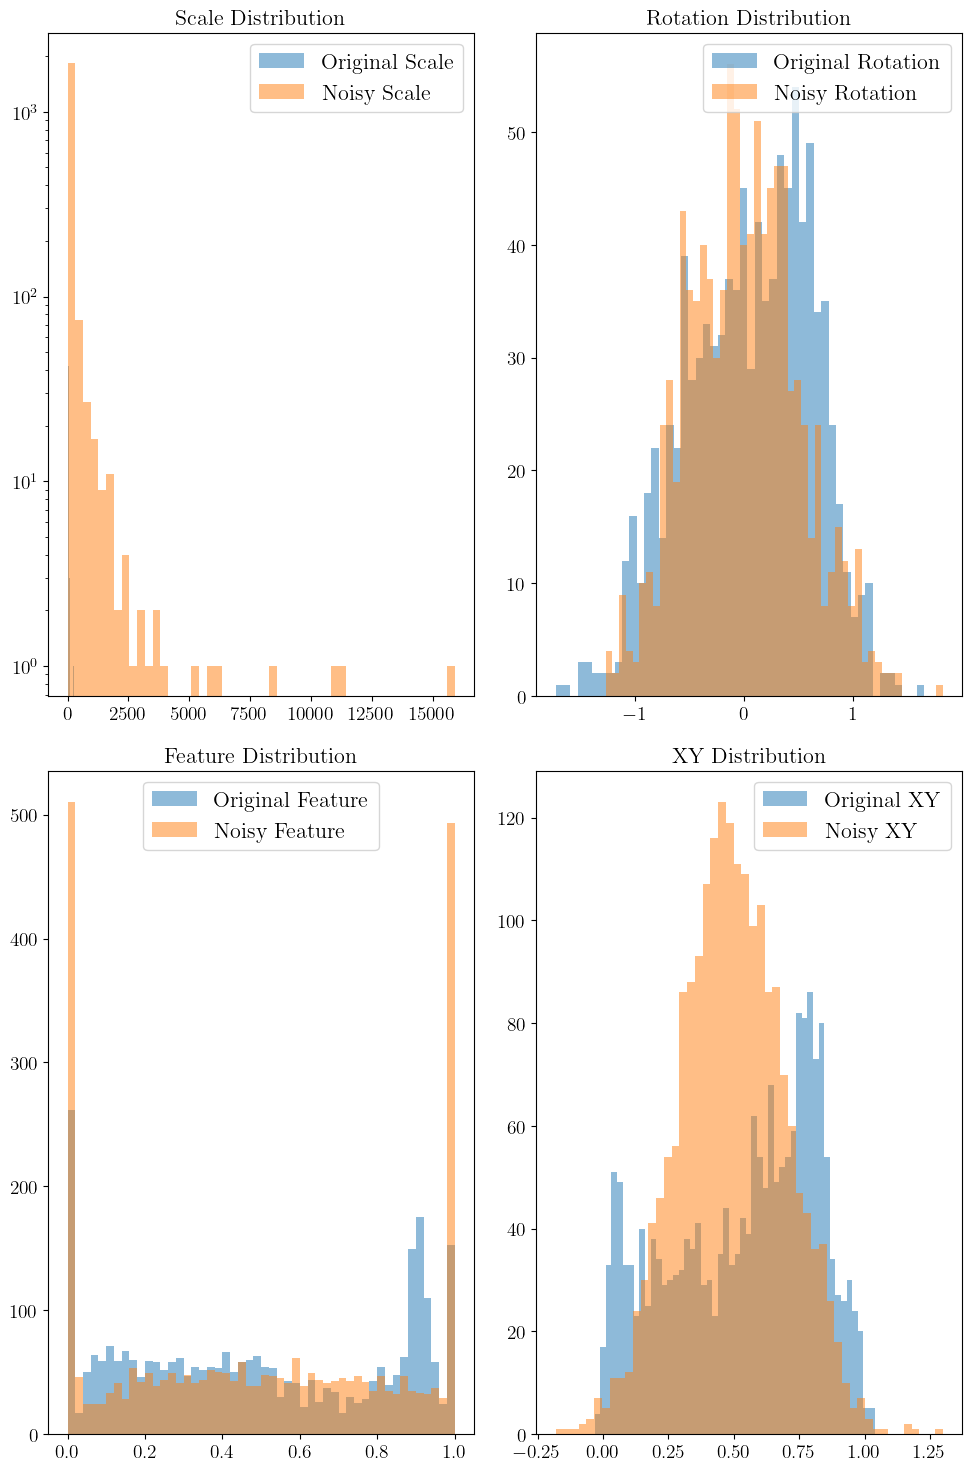

In [4]:
xy_noise = torch.randn_like(xy)
scale_noise = torch.randn_like(scale)
rot_noise = torch.randn_like(rot)
feat_noise = torch.randn_like(feat)

xy_new, scale_new, rot_new, feat_new = denormalize_data(xy_noise, scale_noise, rot_noise, feat_noise)
# let's plot the distributions
fig, axs = plt.subplots(2, 2, figsize=(10, 15))
axs[0, 0].hist(scale.cpu().numpy().flatten(), bins=50, alpha=0.5, label='Original Scale')
axs[0, 0].hist(scale_new.cpu().numpy().flatten(), bins=50, alpha=0.5, label='Noisy Scale')
axs[0, 0].set_yscale('log')
axs[0, 0].set_title('Scale Distribution')
axs[0, 0].legend()  
axs[0, 1].hist(rot.cpu().numpy(), bins=50, alpha=0.5, label='Original Rotation')
axs[0, 1].hist(rot_new.cpu().numpy(), bins=50, alpha=0.5, label='Noisy Rotation')
axs[0, 1].set_title('Rotation Distribution')
axs[0, 1].legend()
axs[1, 0].hist(feat.cpu().numpy().flatten(), bins=50, alpha=0.5, label='Original Feature')
axs[1, 0].hist(feat_new.cpu().numpy().flatten(), bins=50, alpha=0.5, label='Noisy Feature')
axs[1, 0].set_title('Feature Distribution')
axs[1, 0].legend()
axs[1, 1].hist(xy.cpu().numpy().flatten(), bins=50, alpha=0.5, label='Original XY')
axs[1, 1].hist(xy_new.cpu().numpy().flatten(), bins=50, alpha=0.5, label='Noisy XY')
axs[1, 1].set_title('XY Distribution')
axs[1, 1].legend()
plt.tight_layout()
plt.show()

In [5]:
# Letùs render and save the noisy gaussians
noisy_image = render_and_save(xy=xy_new, scale=scale_new, rot=rot_new, feat=feat_new, img_size=image_size, path="output/noisy_image")

In [6]:
diffusion_scheduler = DiffusionScheduler(num_timesteps=1000, beta_start=0.0001, beta_end=0.02, schedule="cosine")

# Move scheduler tensors to the same device as the data
device = xy.device
diffusion_scheduler.sqrt_alphas_cumprod = diffusion_scheduler.sqrt_alphas_cumprod.to(device)
diffusion_scheduler.sqrt_one_minus_alphas_cumprod = diffusion_scheduler.sqrt_one_minus_alphas_cumprod.to(device)

# Create interactive visualization with ipywidgets
from ipywidgets import interact, IntSlider

# Prepare normalized data
xy_norm, scale_norm, rot_norm, feat_norm = normalize_data(xy, scale, rot, feat)

# Stack all parameters into a single tensor for easier processing
# Shape: xy[N, 2], scale[N, 2], rot[N, 1], feat[N, 3] -> all_params[N, 8] -> [1, N, 8]
all_params = torch.cat([xy_norm, scale_norm, rot_norm, feat_norm], dim=1).unsqueeze(0)

# Function to generate noisy image at a specific timestep
def get_noisy_image(timestep):
    if timestep == 0:
        # No noise at timestep 0
        img = render(xy=xy, scale=scale, rot=rot, feat=feat, img_size=image_size)
    else:
        # Generate noise
        noise = torch.randn_like(all_params)
        
        # Add noise according to diffusion schedule
        timesteps = torch.tensor([timestep], dtype=torch.long, device=device)
        noisy_params = diffusion_scheduler.add_noise(all_params, noise, timesteps)
        
        # Unpack parameters: [1, num_gaussians, 8] -> individual components
        noisy_params = noisy_params.squeeze(0)  # [num_gaussians, 8]
        noisy_xy_norm = noisy_params[:, :2]  # [num_gaussians, 2]
        noisy_scale_norm = noisy_params[:, 2:4]  # [num_gaussians, 2]
        noisy_rot_norm = noisy_params[:, 4:5]  # [num_gaussians, 1]
        noisy_feat_norm = noisy_params[:, 5:]  # [num_gaussians, 3]
        
        # Denormalize
        noisy_xy, noisy_scale, noisy_rot, noisy_feat = denormalize_data(
            noisy_xy_norm, noisy_scale_norm, noisy_rot_norm, noisy_feat_norm
        )
        
        # Render
        img = render(xy=noisy_xy, scale=noisy_scale, rot=noisy_rot, feat=noisy_feat, img_size=image_size)
    
    # Convert to CPU numpy array for matplotlib
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
    
    # Convert from (C, H, W) to (H, W, C) for matplotlib
    if img.ndim == 3 and img.shape[0] == 3:
        img = img.transpose(1, 2, 0)
    
    return img

# Interactive visualization function
def visualize_diffusion(timestep):
    img = get_noisy_image(timestep)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title(f'Diffusion Process - Timestep: {timestep}')
    plt.axis('off')
    plt.show()

# Create interactive widget
interact(visualize_diffusion, 
         timestep=IntSlider(min=0, max=diffusion_scheduler.num_timesteps - 1, step=1, value=0, description='Timestep'))


interactive(children=(IntSlider(value=0, description='Timestep', max=999), Output()), _dom_classes=('widget-in…

<function __main__.visualize_diffusion(timestep)>